In [1]:
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,feature_selection
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
from time import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

In [2]:
from sklearn import feature_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [3]:
review1=pd.read_csv('Review_project_sentiment_wUser.csv')

In [4]:
review1.head(2)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,language,text_clean,read_ease,polarity,subjectivity,Adj_ratio,review_count,NumElite,average_stars,NumofWords
0,1073206,JdReKgETiiJEDmshrO4TLw,pyarmAnR-i-qookQamqRTA,V2GOReqPvr8qpCC7sWfoTw,1.0,17,1,0,Just to let this car company that people DO re...,2014-03-06 12:38:52,...,en,let car company people read yelp check review ...,85.49,-0.500000,1.000000,0.120000,9,0,3.00,56
1,6229216,zL4se_Ixdcl8kvTOHCS3rg,s16-BUo-orUsELvMu5ocKg,VH0Ib9S3E-dxbQdQC4rffg,1.0,15,6,4,Mistral was the worst dining experience I have...,2010-07-22 18:08:01,...,en,mistral worst dining experience ever life bad ...,79.19,0.029864,0.502499,0.225888,1777,10,3.82,767


In [5]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=5000, ngram_range=(1,1))

In [6]:
X = review1[["text_clean", "read_ease", "polarity", "subjectivity", 
                           "Adj_ratio",'review_count','NumElite','NumofWords']]

In [7]:
Y = np.array(review1["useful_level"].values)

In [8]:
## split dataset
X_train, X_test,y_train,y_test = model_selection.train_test_split(X,Y, test_size=0.1,stratify=Y)# 10% test size

In [9]:
X_train1, X_valid,y_train1,y_valid = model_selection.train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)# 20% validation

In [10]:
corpus1 = X_train1['text_clean']
vectorizer.fit(corpus1)
X_tfidf_train = vectorizer.transform(corpus1)
dic_vocabulary = vectorizer.vocabulary_

In [11]:
X_tfidf_train

<39734x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2530537 stored elements in Compressed Sparse Row format>

In [12]:
X_valid.shape

(9934, 8)

In [13]:
y_train1.shape

(39734,)

In [14]:
y_valid

array([0, 0, 1, ..., 1, 2, 1], dtype=int64)

In [15]:
y = y_train1
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_tfidf_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [16]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# 0:
  . selected features: 1620
  . top features: amazing,company,food,great,atmosphere,call,told,said,apartment,dog
 
# 1:
  . selected features: 568
  . top features: great,car,apartment,food,said,call,doctor,told,office,company
 
# 2:
  . selected features: 427
  . top features: ride,park,tattoo,ron,food,great,store,grandson,disney,contract
 


In [17]:
# refit vecorizor
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus1)
X_tfidf_train = vectorizer.transform(corpus1)
dic_vocabulary = vectorizer.vocabulary_

In [18]:
X_tfidf_train.shape

(39734, 1702)

In [19]:
X_tfidf_train

<39734x1702 sparse matrix of type '<class 'numpy.float64'>'
	with 1552429 stored elements in Compressed Sparse Row format>

final train set

In [20]:
AllotherTrain  = X_train1[["read_ease", "polarity", "subjectivity", 
                           "Adj_ratio",'review_count','NumElite','NumofWords']]

In [21]:
NewXTrain = pd.DataFrame(X_tfidf_train.toarray(), columns = vectorizer.get_feature_names())

In [22]:
for i in ["read_ease", "polarity", "subjectivity", "Adj_ratio",'review_count','NumElite','NumofWords']:
    NewXTrain[i] = AllotherTrain[i].values

final validation set

In [23]:
AllotherValid = X_valid[["read_ease", "polarity", "subjectivity", 
                           "Adj_ratio",'review_count','NumElite','NumofWords']]

In [24]:
corpus_valid = X_valid['text_clean'].values
X_tfidf_valid=vectorizer.transform(corpus_valid)
#predicted = model.predict(X_tfidf_valid)

In [25]:
NewXValid = pd.DataFrame(X_tfidf_valid.toarray(), columns = vectorizer.get_feature_names())

In [26]:
for i in [ "read_ease", "polarity", "subjectivity", "Adj_ratio",'review_count','NumElite','NumofWords']:
    NewXValid[i] = AllotherValid[i].values

final test set

In [27]:
AllotherTest = X_test[[ "read_ease", "polarity", "subjectivity", 
                           "Adj_ratio",'review_count','NumElite','NumofWords']]

In [28]:
corpus_test = X_test['text_clean'].values
X_tfidf_test=vectorizer.transform(corpus_test)

In [29]:
NewXtest = pd.DataFrame(X_tfidf_test.toarray(), columns = vectorizer.get_feature_names())

In [30]:
for i in ["read_ease", "polarity", "subjectivity", "Adj_ratio",'review_count','NumElite','NumofWords']:
    NewXtest[i] = AllotherTest[i].values

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from time import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import itertools

Model and evalaution on validation

def function

In [36]:
def model_evaluation(model1):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    t0 = time()
    model1.fit(NewXTrain, y_train1.astype(int))
    ## test
    predicted = model1.predict(NewXValid)
    predicted_prob = model1.predict_proba(NewXValid)
    print('Training Time:', time() - t0)
    print('')
    accuracy = metrics.accuracy_score(y_valid, predicted)
    auc = metrics.roc_auc_score(y_valid, predicted_prob, 
                                multi_class="ovr")
    print('\033[1m' + 'Validation Set')
    print('\033[0m')
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print('Macros:')
    print("F1 Score:", f1_score(y_valid, predicted, average='macro'))
    print("Precision:", precision_score(y_valid, predicted, average='macro'))
    print("Recall:", recall_score(y_valid, predicted, average='macro'))
    print('Micros:')
    print("F1 Score:", f1_score(y_valid, predicted, average='micro'))
    print("Precision:", precision_score(y_valid, predicted, average='micro'))
    print("Recall:", recall_score(y_valid, predicted, average='micro'))


    print("Detail Report:")
    print(metrics.classification_report(y_valid, predicted))

    predicted = model1.predict(NewXtest)
    predicted_prob = model1.predict_proba(NewXtest)
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print('\033[1m' + 'Test Set')
    print('\033[0m')
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print('Macros:')
    print("F1 Score:", f1_score(y_test, predicted, average='macro'))
    print("Precision:", precision_score(y_test, predicted, average='macro'))
    print("Recall:", recall_score(y_test, predicted, average='macro'))
    print('Micros:')
    print("F1 Score:", f1_score(y_test, predicted, average='micro'))
    print("Precision:", precision_score(y_test, predicted, average='micro'))
    print("Recall:", recall_score(y_test, predicted, average='micro'))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    #classes = ["0","1","2"]
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.show()

    ## Plot roc
    print("Detail Report:")
    print(metrics.classification_report(y_test, predicted))
    
    y_test1 = label_binarize(y_test, classes=[0, 1, 2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test1[:, i], predicted_prob[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    colors = itertools.cycle(['blue', 'red', 'green'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=0.6,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=0.6)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()
    
     ## Plot precision-recall curve
    
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        plt.plot(recall, precision, lw=1, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    #plt.set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    plt.xlim([0.0,1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

LogisticRegression

C:\Users\Fannie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Time: 11.965726852416992

Validation Set

Accuracy: 0.58
Auc: 0.77
Macros:
F1 Score: 0.4851224034314594
Precision: 0.5493925696425367
Recall: 0.5092650088475953
Micros:
F1 Score: 0.5785182202536743
Precision: 0.5785182202536743
Recall: 0.5785182202536743
Detail Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75      4361
           1       0.46      0.53      0.49      3124
           2       0.53      0.14      0.22      2449

    accuracy                           0.58      9934
   macro avg       0.55      0.51      0.49      9934
weighted avg       0.56      0.58      0.54      9934

Test Set

Accuracy: 0.57
Auc: 0.76
Macros:
F1 Score: 0.4758683099823011
Precision: 0.528977600294327
Recall: 0.5032989982301549
Micros:
F1 Score: 0.5734734553361116
Precision: 0.5734734553361116
Recall: 0.5734734553361116


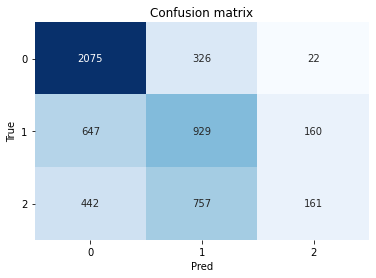

Detail Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.74      2423
           1       0.46      0.54      0.50      1736
           2       0.47      0.12      0.19      1360

    accuracy                           0.57      5519
   macro avg       0.53      0.50      0.48      5519
weighted avg       0.55      0.57      0.53      5519



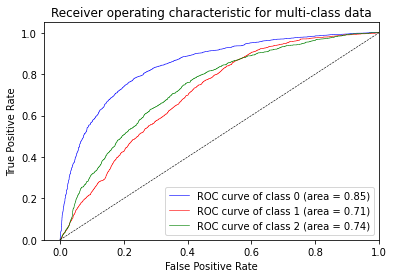

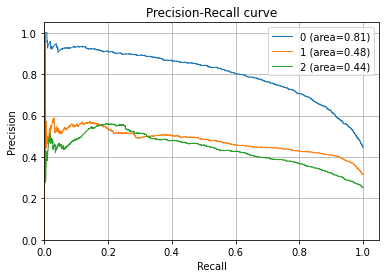

In [37]:
model_evaluation(model1=LogisticRegression(max_iter = 100))

XGB

C:\Users\Fannie\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Time: 90.7134702205658

Validation Set

Accuracy: 0.69
Auc: 0.85
Macros:
F1 Score: 0.6597533176234959
Precision: 0.6826496618647311
Recall: 0.6546865541163706
Micros:
F1 Score: 0.6935776122407892
Precision: 0.6935776122407892
Recall: 0.6935776122407892
Detail Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      4361
           1       0.58      0.64      0.61      3124
           2       0.69      0.46      0.56      2449

    accuracy                           0.69      9934
   macro avg       0.68      0.65      0.66      9934
weighted avg       0.69      0.69      0.69      9934

Test Set

Accuracy: 0.69
Auc: 0

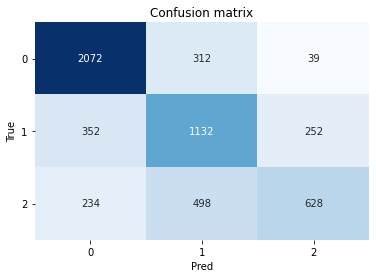

Detail Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2423
           1       0.58      0.65      0.62      1736
           2       0.68      0.46      0.55      1360

    accuracy                           0.69      5519
   macro avg       0.68      0.66      0.66      5519
weighted avg       0.69      0.69      0.69      5519



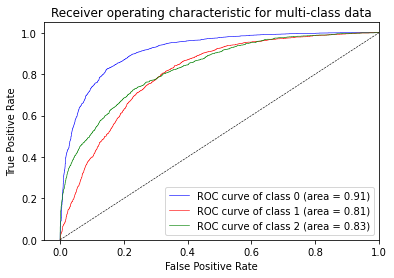

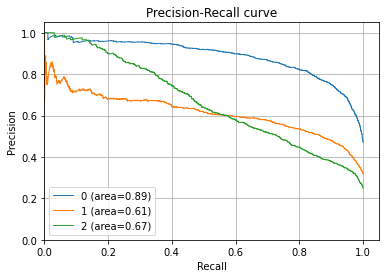

In [38]:
import xgboost as xgb
model_evaluation(model1=xgb.XGBClassifier())

Decision Tree

Training Time: 35.97411251068115

Validation Set

Accuracy: 0.61
Auc: 0.69
Macros:
F1 Score: 0.5855933416117337
Precision: 0.5861965626055113
Recall: 0.5851412435600628
Micros:
F1 Score: 0.6116368028991342
Precision: 0.6116368028991342
Recall: 0.6116368028991342
Detail Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      4361
           1       0.52      0.51      0.51      3124
           2       0.51      0.49      0.50      2449

    accuracy                           0.61      9934
   macro avg       0.59      0.59      0.59      9934
weighted avg       0.61      0.61      0.61      9934

Test Set

Accuracy: 0.6
Auc: 0.69
Macros:
F1 Score: 0.5764856090937375
Precision: 0.5768421124186647
Recall: 0.576187055573897
Micros:
F1 Score: 0.6021018300416742
Precision: 0.6021018300416742
Recall: 0.6021018300416742


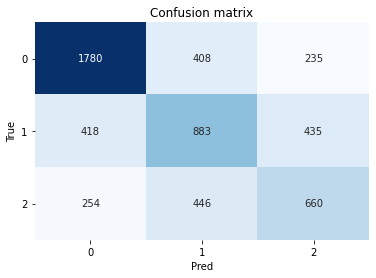

Detail Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2423
           1       0.51      0.51      0.51      1736
           2       0.50      0.49      0.49      1360

    accuracy                           0.60      5519
   macro avg       0.58      0.58      0.58      5519
weighted avg       0.60      0.60      0.60      5519



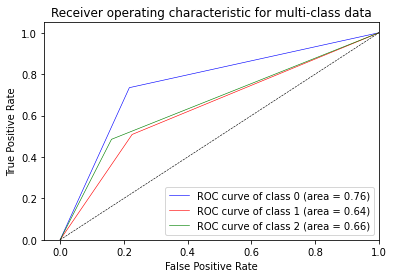

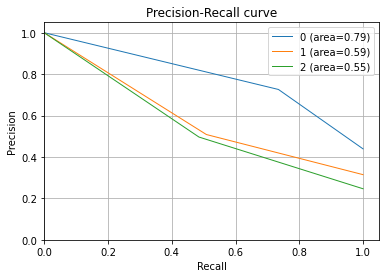

In [39]:
model_evaluation(model1=tree.DecisionTreeClassifier())

KNN

Training Time: 41.27525186538696

Validation Set

Accuracy: 0.62
Auc: 0.75
Macros:
F1 Score: 0.5837382340405084
Precision: 0.6045340198170716
Recall: 0.5799596987338131
Micros:
F1 Score: 0.6218039057781357
Precision: 0.6218039057781357
Recall: 0.6218039057781357
Detail Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      4361
           1       0.52      0.48      0.50      3124
           2       0.61      0.43      0.50      2449

    accuracy                           0.62      9934
   macro avg       0.60      0.58      0.58      9934
weighted avg       0.61      0.62      0.61      9934

Test Set

Accuracy: 0.62
Auc: 0.75
Macros:
F1 Score: 0.5768142002601678
Precision: 0.5953700905677696
Recall: 0.573759650772295
Micros:
F1 Score: 0.6158724406595397
Precision: 0.6158724406595397
Recall: 0.6158724406595397


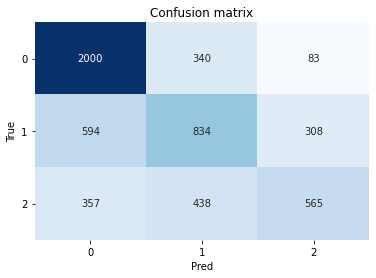

Detail Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.74      2423
           1       0.52      0.48      0.50      1736
           2       0.59      0.42      0.49      1360

    accuracy                           0.62      5519
   macro avg       0.60      0.57      0.58      5519
weighted avg       0.61      0.62      0.60      5519



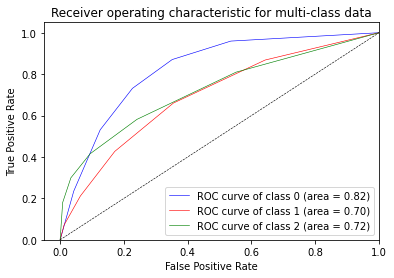

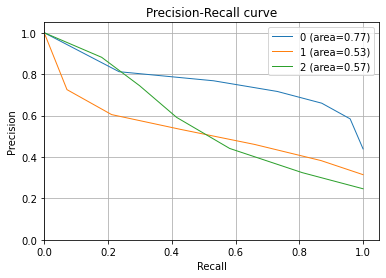

In [40]:
model_evaluation(model1=KNeighborsClassifier())

RandomForest

Training Time: 58.25378632545471

Validation Set

Accuracy: 0.66
Auc: 0.82
Macros:
F1 Score: 0.6030298783504066
Precision: 0.6542802390030006
Recall: 0.6063224529836203
Micros:
F1 Score: 0.6594523857459231
Precision: 0.6594523857459231
Recall: 0.6594523857459231
Detail Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4361
           1       0.54      0.65      0.59      3124
           2       0.68      0.30      0.42      2449

    accuracy                           0.66      9934
   macro avg       0.65      0.61      0.60      9934
weighted avg       0.66      0.66      0.64      9934

Test Set

Accuracy: 0.66
Auc: 0.82
Macros:
F1 Score: 0.6002759918568105
Precision: 0.6521448602004236
Recall: 0.6054339300589167
Micros:
F1 Score: 0.6597209639427433
Precision: 0.6597209639427433
Recall: 0.6597209639427433


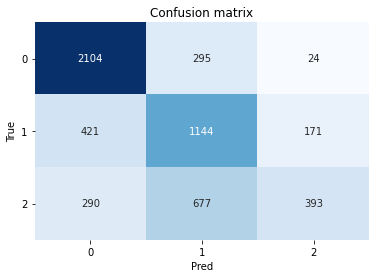

Detail Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      2423
           1       0.54      0.66      0.59      1736
           2       0.67      0.29      0.40      1360

    accuracy                           0.66      5519
   macro avg       0.65      0.61      0.60      5519
weighted avg       0.66      0.66      0.64      5519



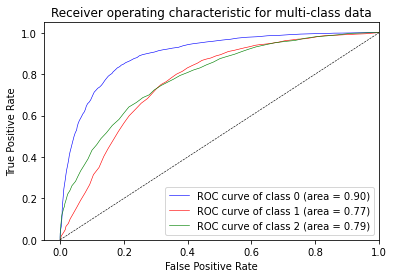

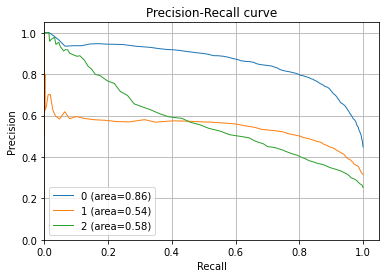

In [41]:
model_evaluation(model1=RandomForestClassifier())

MLP

C:\Users\Fannie\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Time: 493.13345170021057

Validation Set

Accuracy: 0.64
Auc: 0.81
Macros:
F1 Score: 0.6003306424285552
Precision: 0.6039184353883909
Recall: 0.6066261292631627
Micros:
F1 Score: 0.6365009059794645
Precision: 0.6365009059794645
Recall: 0.6365009059794645
Detail Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      4361
           1       0.55      0.41      0.47      3124
           2       0.51      0.58      0.55      2449

    accuracy                           0.64      9934
   macro avg       0.60      0.61      0.60      9934
weighted avg       0.63      0.64      0.63      9934

Test Set

Accuracy: 0.64
Auc: 0.8
Macros:
F1 Score: 0.6011305633289795
Precision: 0.6049360512271363
Recall: 0.6059350168248839
Micros:
F1 Score: 0.6381590867910854
Precision: 0.6381590867910854
Recall: 0.6381590867910854


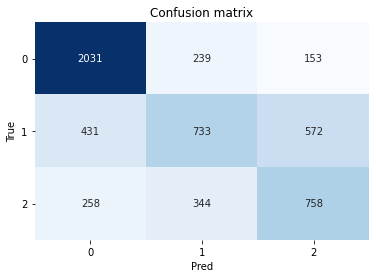

Detail Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      2423
           1       0.56      0.42      0.48      1736
           2       0.51      0.56      0.53      1360

    accuracy                           0.64      5519
   macro avg       0.60      0.61      0.60      5519
weighted avg       0.63      0.64      0.63      5519



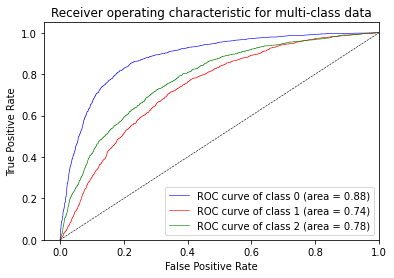

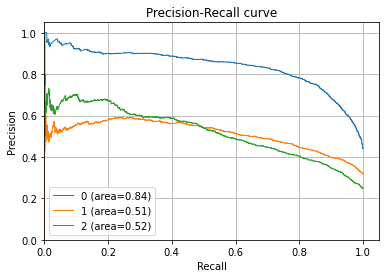

In [42]:
from sklearn.neural_network import MLPClassifier
model_evaluation(model1=MLPClassifier(random_state=1, max_iter=100))